In [2]:
import gym

# Common imports
import numpy as np
import random
import os
import collections

# to make this notebook's output stable across runs
np.random.seed(42)


env = gym.make('CartPole-v1')

# Best random sampling




In [161]:
#obs = []
def get_random_actions(env, seed):
    actions = []

    env.seed(seed)
    env.reset()

    step=0
    while True:
        step+=1
        action = np.random.choice([0,1])
        ob, rewards, terminated, info = env.step(action)
        actions.append(action)
        if terminated: break
    
    return actions


def explore_actions(env, change_node, actions):
    env.seed(seed)
    env.reset()

    new_actions = []
    step=0
    for action in actions[:-change_node]:
        step+=1
        ob, rewards, terminated, info = env.step(action)
        new_actions.append(action)
        if terminated: break

    if not terminated:
        # print("continue to explore", len(new_actions))
        while True:
            step+=1
            action = np.random.choice([0,1])
            ob, rewards, terminated, info = env.step(action)
            new_actions.append(action)
            if terminated: break

    return new_actions


def find_best_actions(env, actions):
    best_actions=[]
    best_obs = []
    for ep in range(30):
        # print(f" {ep} ".center(80, '*'))
        change_node=1
        if len(actions) == 500:
            return actions
        if len(best_actions)>0:
            actions = best_actions
        best_actions = []
        while change_node<len(actions):
            new_actions = explore_actions(env, change_node, actions)
            if len(new_actions)>len(actions):
                # print(len(new_actions), len(actions), change_node)
                if len(new_actions)>len(best_actions):
                    # print(len(new_actions), len(actions), change_node)
                    best_actions=new_actions
            change_node+=1
        
    return best_actions if len(best_actions)>len(actions) else actions


def get_obs(env, actions_result):
    obs_res = []
    for key in actions_result:
        env.seed(key)
        ob = env.reset()
        actions = actions_result[key]
        obs = []
        for action in actions:
            obs.append(ob)
            ob, rewards, terminated, info = env.step(action)
            
            if terminated: break
        
        obs_res.append(np.array(obs))
    
    return obs_res



In [31]:
# seed = 10
# actions = get_random_actions(env, seed)
# best_actions = find_best_actions(env, actions)

In [32]:
len(actions), len(best_actions)

(12, 308)

In [105]:
res = {}
seeds = [0, 1, 5, 10, 21, 42, 47, 63, 84, 100, 121, 144]
for seed in seeds:
    actions = get_random_actions(env, seed)
    best_actions = find_best_actions(env, actions)
    print(f"[{seed}] Actions length improvement:",len(actions), "->", len(best_actions))
    res[seed] = best_actions

[0] Actions length improvement: 21 -> 399
[1] Actions length improvement: 17 -> 492
[5] Actions length improvement: 15 -> 500
[10] Actions length improvement: 11 -> 500
[21] Actions length improvement: 15 -> 500
[42] Actions length improvement: 21 -> 500
[47] Actions length improvement: 26 -> 500
[63] Actions length improvement: 27 -> 428
[84] Actions length improvement: 18 -> 500
[100] Actions length improvement: 30 -> 161
[121] Actions length improvement: 12 -> 500
[144] Actions length improvement: 23 -> 196


In [199]:
obs = get_obs(env, res)
array_obs = np.concatenate(obs[:])
array_obs.shape

(5176, 4)

In [190]:
array_actions = np.concatenate([np.array(act[1]) for act in res.items()][:])

# Plot data

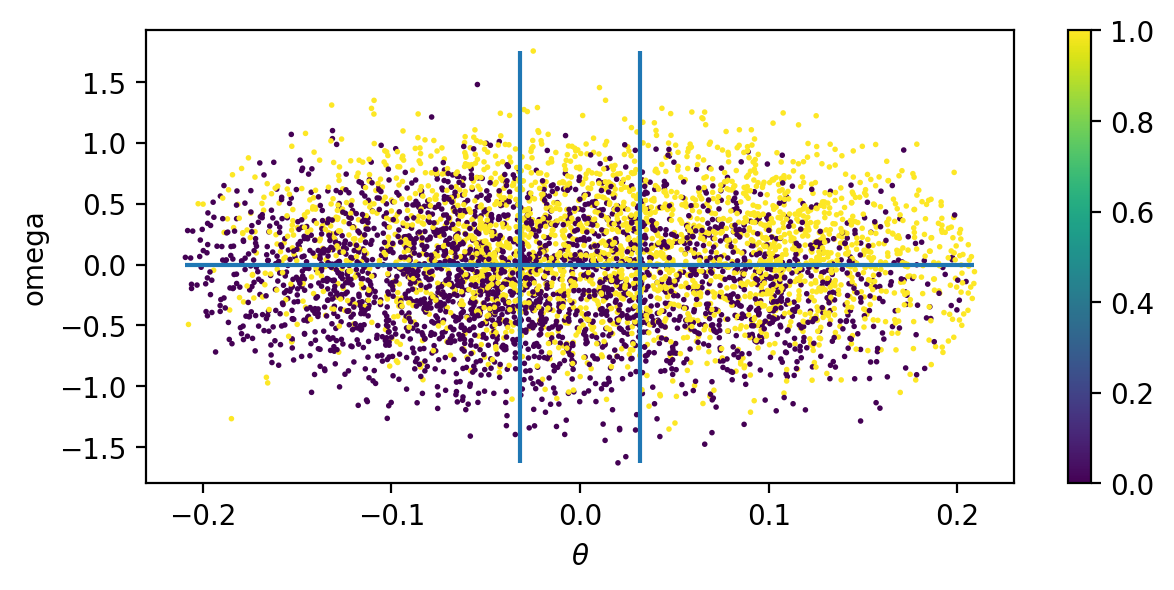

In [191]:
import matplotlib.pyplot as plt

color = array_actions
speed = array_obs[:, 3]
theta = array_obs[:, 2]
plt.figure(figsize=(7, 3), dpi=200)
plt.scatter(theta, speed, c=color, s=1), #print(obs[:, 2].shape)
plt.vlines([0.032, -0.032], ymin=min(speed), ymax=max(speed))
plt.hlines([0], xmin=min(theta), xmax=max(theta))
plt.xlabel(r'$\theta$')
plt.ylabel('omega')
plt.colorbar();

# Train LightGBM

In [202]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

lbc = LGBMClassifier(n_estimators=200)

lbc.fit(array_obs, array_actions)
accuracy_score(array_actions, lbc.predict(array_obs))

0.9296754250386399

In [203]:
lbc.feature_importances_

array([2089, 2002, 2456, 2453])

# Test model on environment
It suuucks, I saved *next_obs* and not the actual obs

In [204]:
for seed in range(1, 200, 5):
    env.seed(seed)
    ob = env.reset()

    step = 0
    while True:
        # print(ob.reshape(1, -1).shape)
        action = lbc.predict(ob.reshape(1, -1))[0]
        # action = res[seeds[4]][step]
        ob, reward, terminated, info = env.step(action)
        step+=1
        if terminated: reward*=-1;break
        
    print(seed, ':',step)

1 : 500
6 : 500
11 : 500
16 : 500
21 : 500
26 : 500
31 : 500
36 : 500
41 : 500
46 : 500
51 : 500
56 : 500
61 : 315
66 : 500
71 : 500
76 : 500
81 : 500
86 : 238
91 : 500
96 : 500
101 : 500
106 : 500
111 : 334
116 : 385
121 : 500
126 : 500
131 : 500
136 : 500
141 : 500
146 : 500
151 : 500
156 : 500
161 : 500
166 : 500
171 : 500
176 : 500
181 : 306
186 : 500
191 : 500
196 : 459


0